## Check the file paths

In [10]:
import sys
from pathlib import Path

# Get the current working directory (Jupyter doesn't have __file__)
PROJECT_ROOT = Path.cwd()

# Ensure the root directory is correct (adjust if necessary)
if (PROJECT_ROOT / "config.py").exists():
    sys.path.append(str(PROJECT_ROOT))
else:
    # Move one level up if the notebook is inside a subdirectory
    PROJECT_ROOT = PROJECT_ROOT.parent
    sys.path.append(str(PROJECT_ROOT))

Project Root: /Users/lau/Documents/UNI/3. Semester/Project Computer Vision/project/My Project
Models Path: /Users/lau/Documents/UNI/3. Semester/Project Computer Vision/project/My Project/models
Datasets Path: /Users/lau/Documents/UNI/3. Semester/Project Computer Vision/project/My Project/data_sets
Models Path: /Users/lau/Documents/UNI/3. Semester/Project Computer Vision/project/My Project/models


## Imports

In [11]:
from ultralytics import YOLO
import cv2 
from matplotlib import pyplot as plt
import time
import psutil

import config

## Load model 

In [12]:
# Load models
v8n_person = YOLO(str(config.YOLOV8_PERSON))
v8n_mask = YOLO(str(config.YOLOV8_MASK))
v11n_person = YOLO(str(config.YOLOV11_PERSON))
v11n_mask = YOLO(str(config.YOLOV11_MASK))

# Create model list
model_dict = {"v8n_person":v8n_person, "v8n_mask":v8n_mask, "v11n_person":v11n_person, "v11n_mask":v11n_mask}

## Test if model was loaded correctly

In [13]:
# Function to plot result images
def matplot_image(results: list, model_name: str):
    """
        Display the image using matplotlib
        :param results: list of results from the model
        :param model_name: name of the model
    """

    im  = results[0].plot()
    # Convert BGR (OpenCV format) to RGB (matplotlib format)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    # Add model name to the image
    plt.title(model_name)

    # Display the image using matplotlib
    plt.imshow(im_rgb)
    plt.axis("off")  # Turn off axes for a cleaner display
    plt.show()


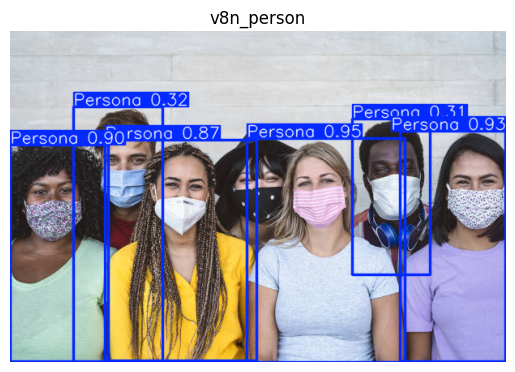

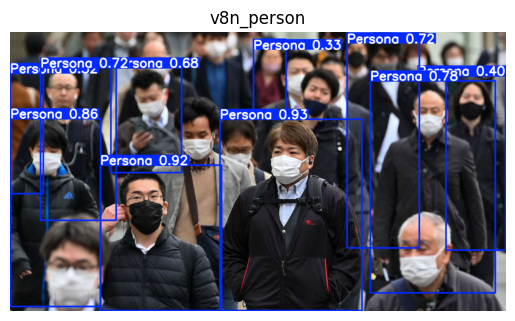

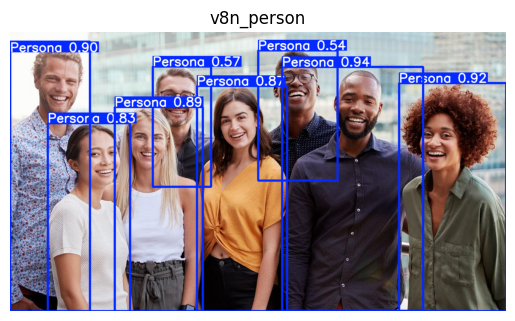

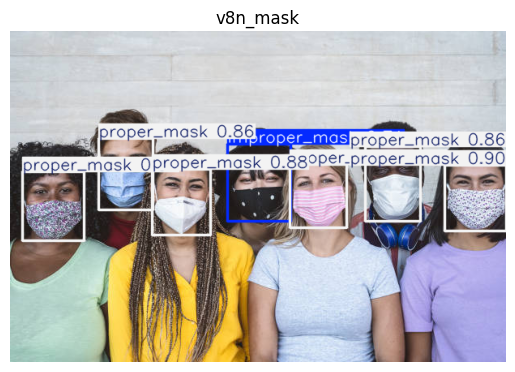

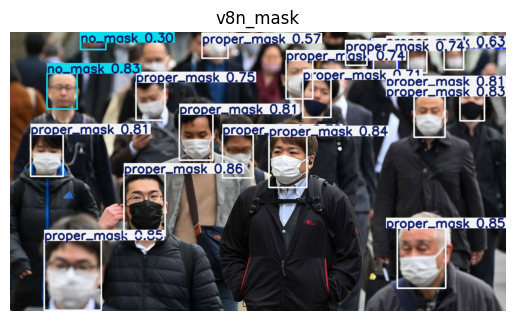

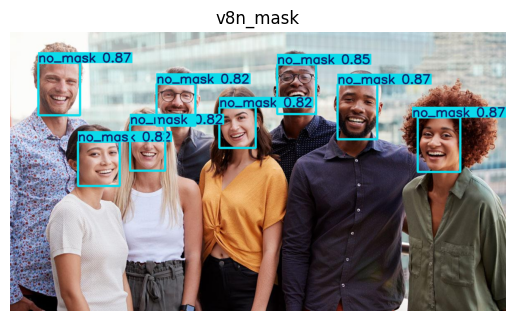

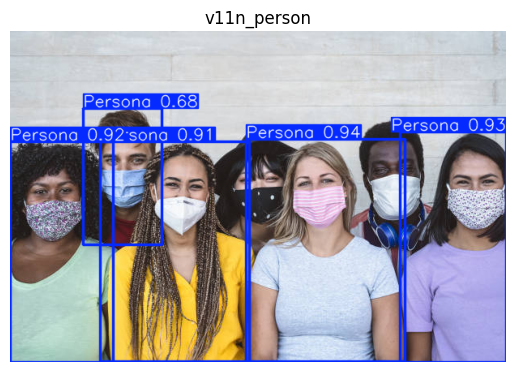

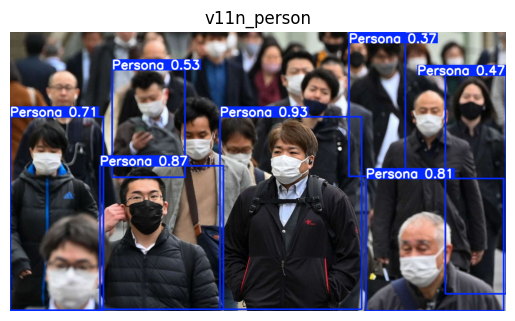

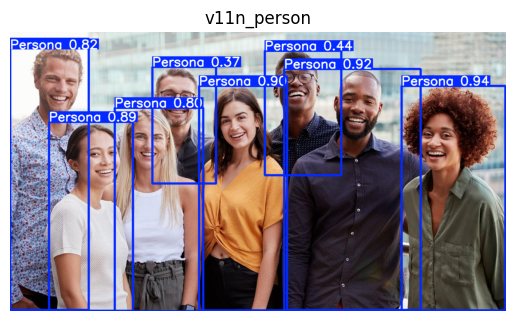

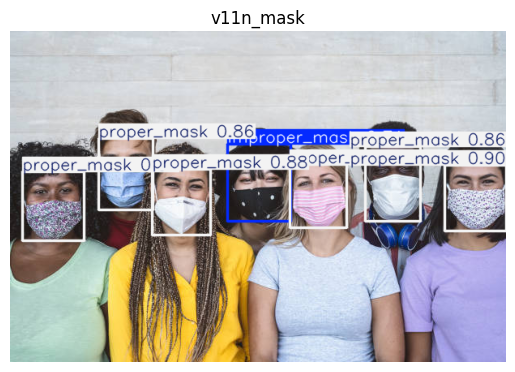

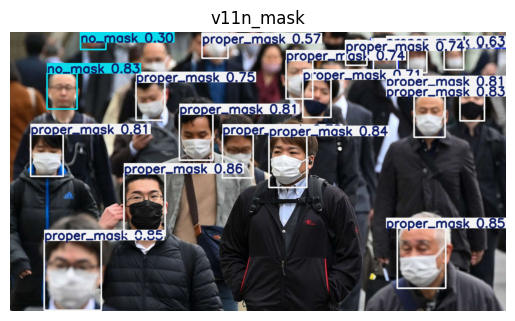

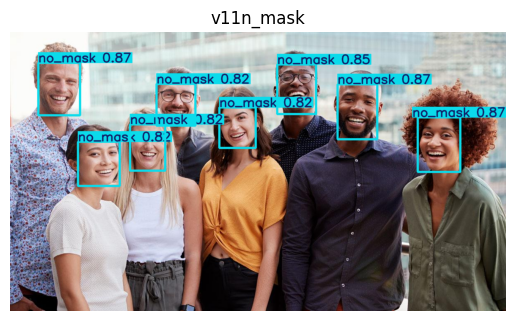

In [14]:
# Set confidence and IOU threshold
conf = 0.3
iou = 0.3

# Test models
for model_name, model in model_dict.items():
    for i in range(3):
        results = model.predict(f"../data_sets/image_data/mask_person_test/{i}.jpg", conf=conf, iou=iou, verbose=False)

        # Show results
        matplot_image(results, model_name)

## Get RAM usage

In [15]:
# Get RAM usage
def get_ram_usage():
    """
        Get the RAM usage of the system
        :return: RAM usage in MB
    """


    # Get current process
    process = psutil.Process()

    # Get memory usage in bytes and convert to MB
    return process.memory_info().rss / (1024 ** 2)  # Resident Set Size (RSS)
    

## Put stats bar on frame

In [16]:
# Put stats bar on frame
def put_stats_bar(frame, t0_inf=0, t1_inf=0, t0_ann=0, t1_ann=0, loop_time=0, bar_height=30,font_scale=0.5, font_thickness=1):
    """
        Add a stats bar at the bottom of the frame
        :param frame: frame to add the stats bar to
        :param t0_inf: start time of inference
        :param t1_inf: end time of inference
        :param t0_ann: start time of annotation
        :param t1_ann: end time of annotation
        :param loop_time: time taken to process the frame
        :param bar_height: height of the stats bar
        :param font_scale: font scale of the text
        :param font_thickness: font thickness of the text
    """

    # Calculate inference time
    inference_time = (t1_inf - t0_inf) * 1000  # Convert to milliseconds
    
    # Calculate annotation time
    annotation_time = (t1_ann - t0_ann) * 1000  # Convert to milliseconds

    # Calculate max FPS
    max_fps = 1 / loop_time if loop_time > 0 else 0

    # Add text inside the rectangle
    stats_text = (
    f"Inference time: {inference_time:.2f} ms | "
    f"Annotation time: {annotation_time:.2f} ms | "
    f"Max FPS: {max_fps:.2f}"
    f"      Press 'q' to quit | Press '+' to increase confidence | Press '-' to decrease confidence"
    )
        
    # Add a rectangle at the bottom of the frame
    h, w, _ = frame.shape  # Get frame dimensions
    cv2.rectangle(frame, (0, h - bar_height), (w, h), (0, 0, 0), -1)  # Black rectangle

    # Add text inside the rectangle
    text_color = (255, 255, 255)  # White text
    cv2.putText(frame, stats_text, (10, h - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, font_thickness)

## Test Webcam as input

## Test mp4 as input

In [17]:
# Set confidence and IOU threshold
conf_tresh = 0.3
iou_tresh = 0.3
pred_framerate = 2
model_person = v8n_person
model_mask = v8n_mask

# Initialize VideoCapture
cap = cv2.VideoCapture("../data_sets/video_data/zeitlupenszene-massen-von-asiaten-menschen-tragen-gesichtsschutz-in-der-prävention-für.mp4")

frame_count = 0
start_time = time.time()
loop_time = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % pred_framerate == 0:
        # Perform inference for person and mask models
        t0_inf = time.time()    # Start time
        result_person = model_person(frame, conf=conf_tresh, iou=iou_tresh) 
        result_mask = model_mask(frame, conf=conf_tresh, iou=iou_tresh)
        frame_count = 0 # Reset frame count
        t1_inf = time.time()    # End time

        loop_time = (time.time() - start_time)/pred_framerate
        start_time = time.time()

    t0_ann = time.time()    # Start time
    # Extract bounding boxes, confidences, and labels from both models
    for i in range(len(result_mask[0].boxes.cls)):
        x1, y1, x2, y2 = map(int, result_mask[0].boxes.xyxy[i])
        clss, conf = result_mask[0].boxes.cls[i], result_mask[0].boxes.conf[i]
        text = f"{model_mask.names[int(clss)]} ({conf:.2f})"

        if int(clss) == 0:
            colorcode = (255, 165, 0)
        elif int(clss) == 1:
            colorcode = (0, 0, 255)
        elif int(clss) == 2:
            colorcode = (0,255,0)
        cv2.rectangle(frame, (x1, y1), (x2, y2), colorcode, 2)  # Red for model 2
        cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, colorcode, 2)

    for i in range(len(result_person[0].boxes.cls)):
        x1, y1, x2, y2 = map(int, result_person[0].boxes.xyxy[i])
        clss, conf = result_person[0].boxes.cls[i], result_person[0].boxes.conf[i]
        text = f"{model_person.names[int(clss)]} ({conf:.2f})"

        colorcode = (255, 0, 0)
        cv2.rectangle(frame, (x1, y1), (x2, y2), colorcode, 2)  # Red for model 2
        cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, colorcode, 2)
    
    # Quit with 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Quit with 'q'
        break
    t1_ann = time.time()    # End time

    # Add stats bar to the frame
    put_stats_bar(frame, t0_inf, t1_inf, t0_ann, t1_ann, loop_time, 30, 0.5, 1)

    # Show the frame with bounding boxes
    cv2.imshow("Detections", frame)        
    frame_count += 1

cap.release()
cv2.destroyAllWindows()




2025-02-07 09:32:46.218 Python[36440:2078691] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-07 09:32:46.218 Python[36440:2078691] +[IMKInputSession subclass]: chose IMKInputSession_Modern
